In [ ]:
#
# Practical 3.1 - Text Classification with RNNs
#

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from tqdm import tqdm
from pprint import pprint

from lib.data import (
    batch_pad_truncate_dataset,
    load_TED_dataset,
    drop_data_of_label,
)
from lib.text import (
    build_encoder_decoder_from_vocab,
    parse_text_to_tokenised_sentences,
)
from lib.plot import plot_frequency_map
from lib.model import train_evaluate_model

In [2]:
#
# Load Dataset
#


def keywords_to_labels(keywords):
    label_codes = [
        label_keyword.upper()[0] if label_keyword in keywords.lower() else "o"
        for label_keyword in ["technology", "entertainment", "design"]
    ]

    return "".join(label_codes)


content_text, keywords_text = load_TED_dataset(include_keywords=True)

flat_tokenised_clips = [
    [
        word
        for sentence in parse_text_to_tokenised_sentences(clip)
        for word in ["_BOS_", *sentence, "_EOS_"]
    ]
    for clip in tqdm(content_text)
]
labels = list(map(keywords_to_labels, keywords_text))
dataset = list(zip(flat_tokenised_clips, labels))

del content_text, keywords_text, flat_tokenised_clips, labels

ted_en-20160408.zip already downloaded.


100%|██████████| 2085/2085 [00:03<00:00, 561.50it/s]


In [5]:
# %%
# Build Encoder
#
vocab = set([word for (clip, label) in dataset for word in clip])
encoder, _ = build_encoder_decoder_from_vocab(vocab)
print(len(encoder))
print(encoder['_BOS_'])

54197
54195


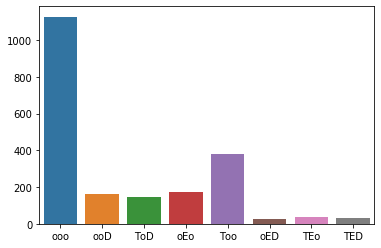

In [4]:
# 
# Optinoal: actively drop out samples with certain labels in the dataset 
# to check if balanced label distribution help improve model performance
#
plot_frequency_map([label for (content, label) in dataset])

balanced_dataset = drop_data_of_label(dataset, "ooo", 0)

plot_frequency_map([label for (content, label) in balanced_dataset])

In [5]:
#
# Encode Dataset
#

label_encoder = {
    "TEo": 0,
    "oEo": 1,
    "Too": 2,
    "oED": 3,
    "ToD": 4,
    "ooD": 5,
    "ooo": 6,
    "TED": 7,
}


def encode_dataset(dataset, encoder, label_encoder):
    output = [
        ([encoder[word] for word in clip], label_encoder[label])
        for (clip, label) in tqdm(dataset)
    ]
    return output


def pad_to_longest_clip(encoded_dataset):
    # pad each clip to the same length as longest clip
    longest_clip = max([len([word for word in clip]) for (clip, _) in encoded_dataset])

    output = [
        (
            np.append(encoded_clip, np.zeros(longest_clip - len(encoded_clip), dtype=int),),
            encoded_label,
        )
        for (encoded_clip, encoded_label) in tqdm(encoded_dataset)
    ]

    return output


encoded_dataset = pad_to_longest_clip(
    encode_dataset(balanced_dataset, encoder, label_encoder)
)

print(np.array(encoded_dataset).shape)
print(encoded_dataset[0])

100%|██████████| 2085/2085 [00:00<00:00, 4493.95it/s]

(2085, 2)
(array([32284, 22099, 48018, ...,     0,     0,     0]), 6)


In [6]:
# 
# Hyper-Parameters
#

ENCODER_SIZE = len(encoder)
EMBEDDING_SIZE = 100

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 193s 115ms/sample - loss: 1.7608 - accuracy: 0.5362 - val_loss: 1.5227 - val_accuracy: 0.5433
Epoch 2/10
1669/1669 [==============================] - 189s 113ms/sample - loss: 1.4481 - accuracy: 0.5470 - val_loss: 1.4742 - val_accuracy: 0.5433
Epoch 3/10
1669/1669 [==============================] - 189s 113ms/sample - loss: 1.4351 - accuracy: 0.5470 - val_loss: 1.5055 - val_accuracy: 0.5433
Epoch 4/10
1669/1669 [==============================] - 189s 113ms/sample - loss: 1.4311 - accuracy: 0.5470 - val_loss: 1.4681 - val_accuracy: 0.5433
Epoch 5/10
1669/1669 [==============================] - 187s 112ms/sample - loss: 1.4134 - accuracy: 0.5470 - val_loss: 1.4478 - val_accuracy: 0.5433
Epoch 6/10
1669/1669 [==============================] - 188s 113ms/sample - loss: 1.3989 - accuracy: 0.5470 - val_loss: 1.4430 - val_accuracy: 0.5433
Epoch 7/10
1669/1669 [===

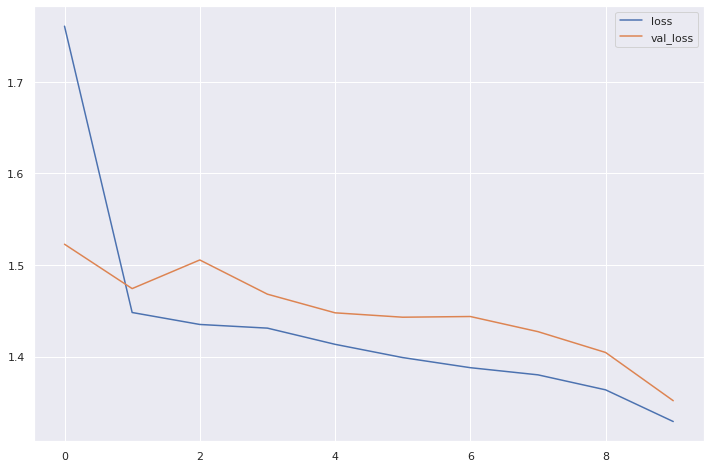

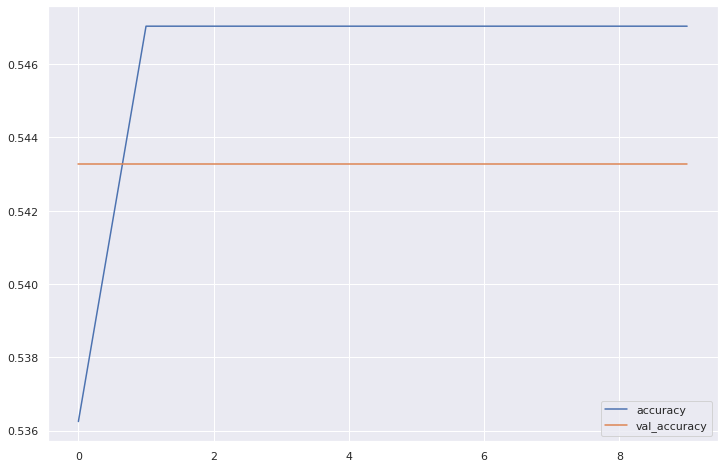

In [9]:
# 
# Model 1 - average hidden states of the whole sequence from RNN as doc representation
#

tf.keras.backend.clear_session()


class RNNCell(layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(RNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units), initializer="uniform", name="kernel"
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer="uniform",
            name="recurrent_kernel",
        )
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = inputs @ self.kernel
        output = h + prev_output @ self.recurrent_kernel
        return output, [output]


model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.RNN(RNNCell(128), return_sequences=True),
        layers.GlobalAveragePooling1D(),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 318s 191ms/sample - loss: 1.7994 - accuracy: 0.5153 - val_loss: 1.6429 - val_accuracy: 0.5000
Epoch 2/10
1669/1669 [==============================] - 312s 187ms/sample - loss: 1.4511 - accuracy: 0.5464 - val_loss: 1.5453 - val_accuracy: 0.5000
Epoch 3/10
1669/1669 [==============================] - 311s 186ms/sample - loss: 1.4205 - accuracy: 0.5464 - val_loss: 1.5010 - val_accuracy: 0.5000
Epoch 4/10
1669/1669 [==============================] - 310s 186ms/sample - loss: 1.4177 - accuracy: 0.5464 - val_loss: 1.4964 - val_accuracy: 0.5000
Epoch 5/10
1669/1669 [==============================] - 310s 186ms/sample - loss: 1.4175 - accuracy: 0.5464 - val_loss: 1.4964 - val_accuracy: 0.5000
Epoch 6/10
1669/1669 [==============================] - 309s 185ms/sample - loss: 1.4135 - accuracy: 0.5464 - val_loss: 1.4876 - val_accuracy: 0.5000
Epoch 7/10
1669/1669 [===

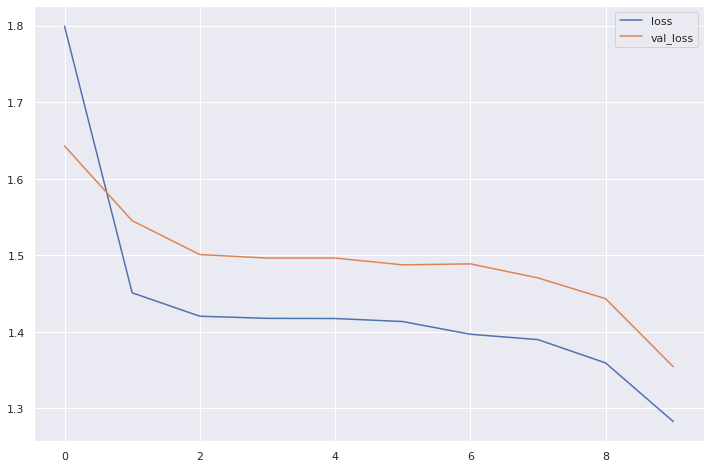

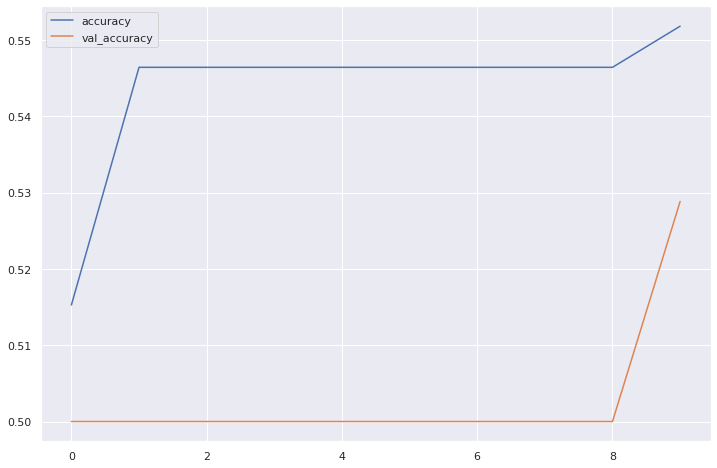

In [10]:
# 
# Model 2 - average hidden states of the whole sequence from GRU as doc representation
#
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.GRU(128, return_sequences=True),
        layers.GlobalAveragePooling1D(),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 11s 7ms/sample - loss: 1.7299 - accuracy: 0.5117 - val_loss: 1.5013 - val_accuracy: 0.5144
Epoch 2/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4550 - accuracy: 0.5464 - val_loss: 1.4202 - val_accuracy: 0.5144
Epoch 3/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4325 - accuracy: 0.5464 - val_loss: 1.4210 - val_accuracy: 0.5144
Epoch 4/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4281 - accuracy: 0.5464 - val_loss: 1.4188 - val_accuracy: 0.5144
Epoch 5/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4232 - accuracy: 0.5464 - val_loss: 1.4153 - val_accuracy: 0.5144
Epoch 6/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4141 - accuracy: 0.5464 - val_loss: 1.4008 - val_accuracy: 0.5144
Epoch 7/10
1669/1669 [=====================

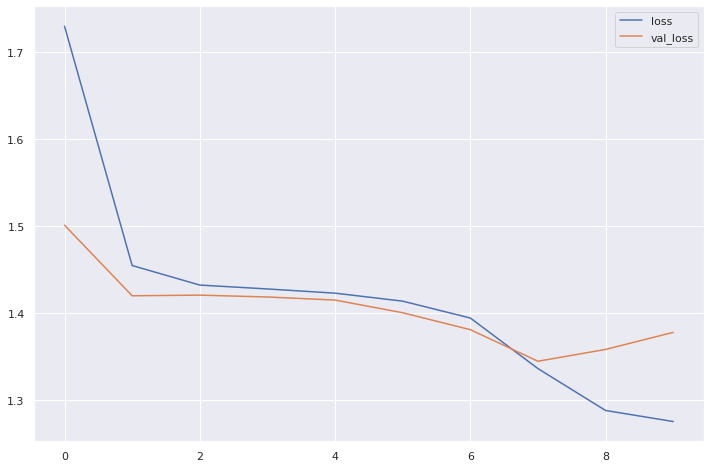

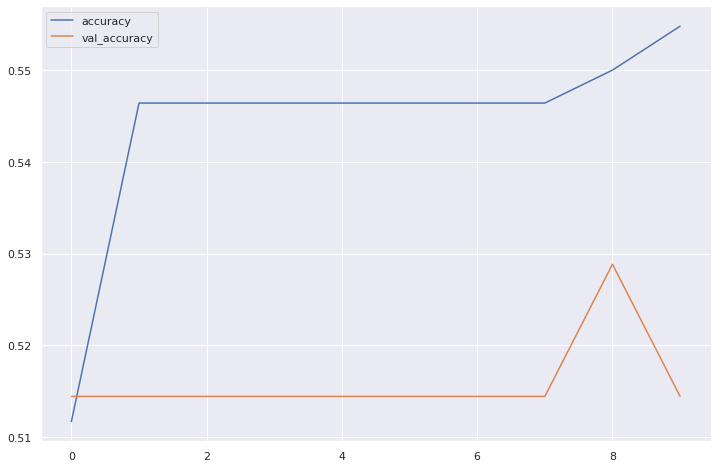

In [9]:
# 
# Model 3 - average hidden states of the whole sequence from LSTM as doc representation
#

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.LSTM(128, return_sequences=True),
        layers.GlobalAveragePooling1D(),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 30s 18ms/sample - loss: 1.7101 - accuracy: 0.5093 - val_loss: 1.4755 - val_accuracy: 0.5385
Epoch 2/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4415 - accuracy: 0.5386 - val_loss: 1.4236 - val_accuracy: 0.5385
Epoch 3/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4339 - accuracy: 0.5386 - val_loss: 1.4253 - val_accuracy: 0.5385
Epoch 4/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4337 - accuracy: 0.5386 - val_loss: 1.4304 - val_accuracy: 0.5385
Epoch 5/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4331 - accuracy: 0.5386 - val_loss: 1.4249 - val_accuracy: 0.5385
Epoch 6/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4340 - accuracy: 0.5386 - val_loss: 1.4208 - val_accuracy: 0.5385
Epoch 7/10
1669/1669 [====================

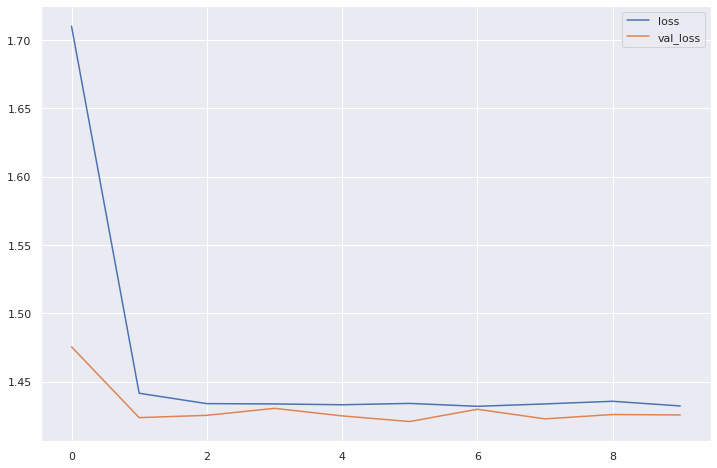

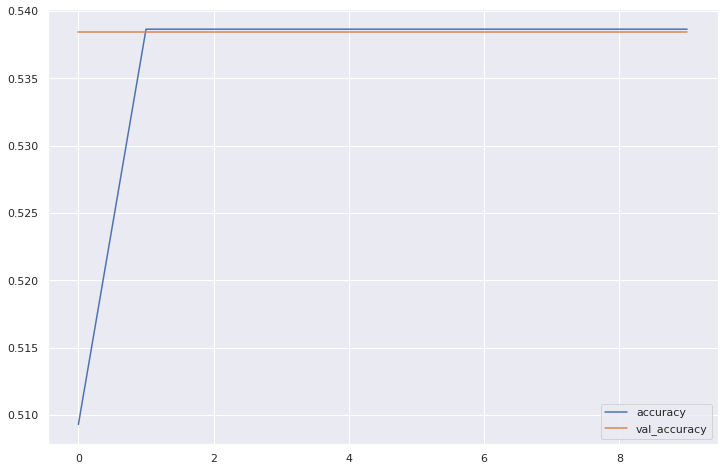

In [9]:
# 
# Model 4 - cell state from last timestep in LSTM
#

tf.keras.backend.clear_session()

input_layer = layers.Input(shape=(len(encoded_dataset[0][0]),))
embedding_layer = layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE).apply(
    input_layer
)
lstm_layer = layers.LSTM(128, return_sequences=True, return_state=True).apply(
    embedding_layer
)
output_layer = layers.Dense(8, activation="softmax").apply(lstm_layer[1])

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 14s 8ms/sample - loss: 1.6961 - accuracy: 0.5009 - val_loss: 1.5366 - val_accuracy: 0.5192
Epoch 2/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4348 - accuracy: 0.5428 - val_loss: 1.5060 - val_accuracy: 0.5192
Epoch 3/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4244 - accuracy: 0.5428 - val_loss: 1.5067 - val_accuracy: 0.5192
Epoch 4/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4249 - accuracy: 0.5428 - val_loss: 1.4961 - val_accuracy: 0.5192
Epoch 5/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4253 - accuracy: 0.5428 - val_loss: 1.5097 - val_accuracy: 0.5192
Epoch 6/10
1669/1669 [==============================] - 10s 6ms/sample - loss: 1.4236 - accuracy: 0.5428 - val_loss: 1.4983 - val_accuracy: 0.5192
Epoch 7/10
1669/1669 [=====================

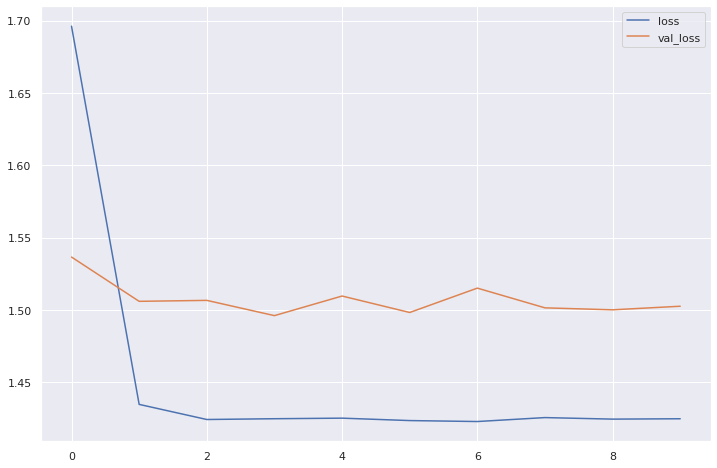

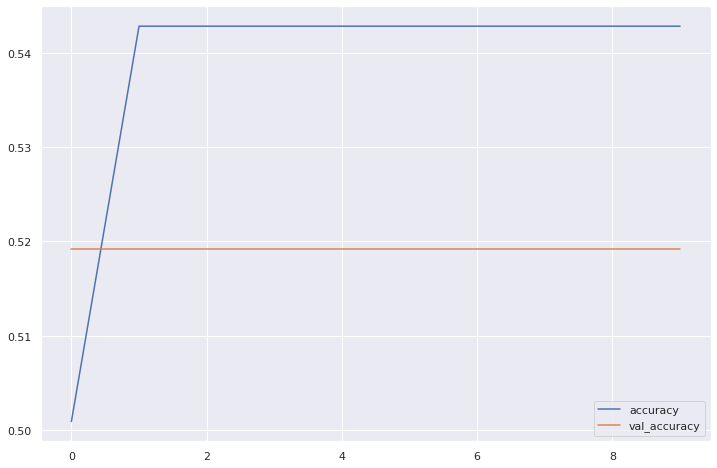

In [9]:
# 
# Model 5 - hidden state output from last timestep in LSTM
#

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.LSTM(128),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 21s 12ms/sample - loss: 1.7444 - accuracy: 0.5135 - val_loss: 1.6033 - val_accuracy: 0.5144
Epoch 2/10
1669/1669 [==============================] - 8s 5ms/sample - loss: 1.4344 - accuracy: 0.5464 - val_loss: 1.5447 - val_accuracy: 0.5144
Epoch 3/10
1669/1669 [==============================] - 8s 5ms/sample - loss: 1.4157 - accuracy: 0.5464 - val_loss: 1.5300 - val_accuracy: 0.5144
Epoch 4/10
1669/1669 [==============================] - 8s 5ms/sample - loss: 1.4139 - accuracy: 0.5464 - val_loss: 1.5197 - val_accuracy: 0.5144
Epoch 5/10
1669/1669 [==============================] - 8s 5ms/sample - loss: 1.4144 - accuracy: 0.5464 - val_loss: 1.5299 - val_accuracy: 0.5144
Epoch 6/10
1669/1669 [==============================] - 8s 5ms/sample - loss: 1.4145 - accuracy: 0.5464 - val_loss: 1.5249 - val_accuracy: 0.5144
Epoch 7/10
1669/1669 [=========================

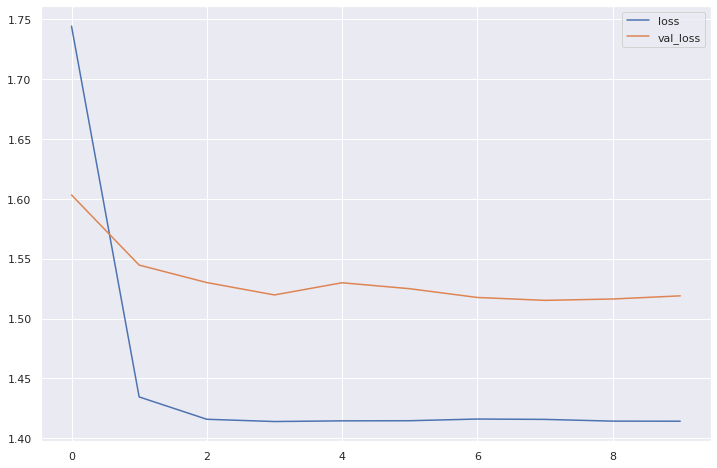

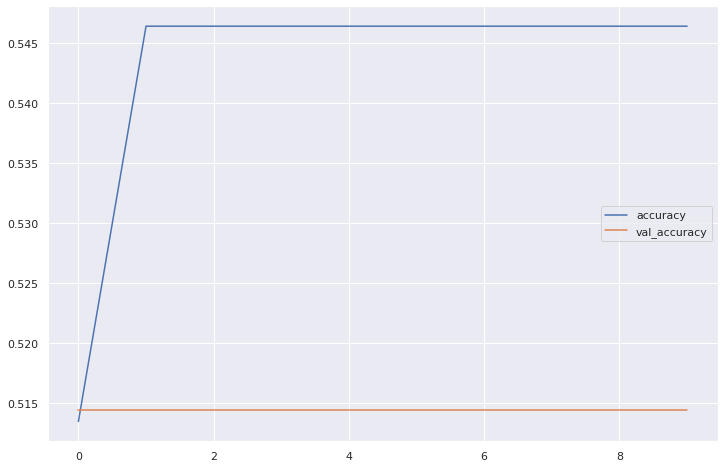

In [8]:
# 
# Model 6 - hidden state output from last timestep in GRU
#

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.GRU(128),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 28s 17ms/sample - loss: 1.6000 - accuracy: 0.5141 - val_loss: 1.5533 - val_accuracy: 0.4615
Epoch 2/10
1669/1669 [==============================] - 24s 14ms/sample - loss: 1.4270 - accuracy: 0.5476 - val_loss: 1.5533 - val_accuracy: 0.4615
Epoch 3/10
1669/1669 [==============================] - 23s 14ms/sample - loss: 1.4241 - accuracy: 0.5476 - val_loss: 1.5590 - val_accuracy: 0.4615
Epoch 4/10
1669/1669 [==============================] - 23s 14ms/sample - loss: 1.4152 - accuracy: 0.5476 - val_loss: 1.5509 - val_accuracy: 0.4615
Epoch 5/10
1669/1669 [==============================] - 23s 14ms/sample - loss: 1.4162 - accuracy: 0.5476 - val_loss: 1.5544 - val_accuracy: 0.4615
Epoch 6/10
1669/1669 [==============================] - 23s 14ms/sample - loss: 1.4158 - accuracy: 0.5476 - val_loss: 1.5660 - val_accuracy: 0.4615
Epoch 7/10
1669/1669 [===============

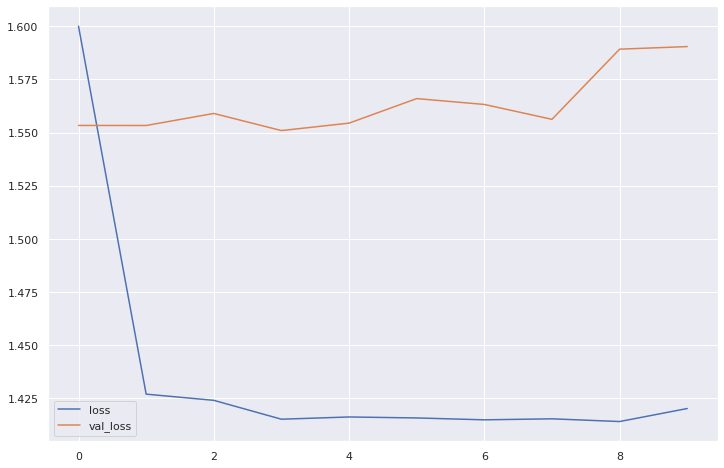

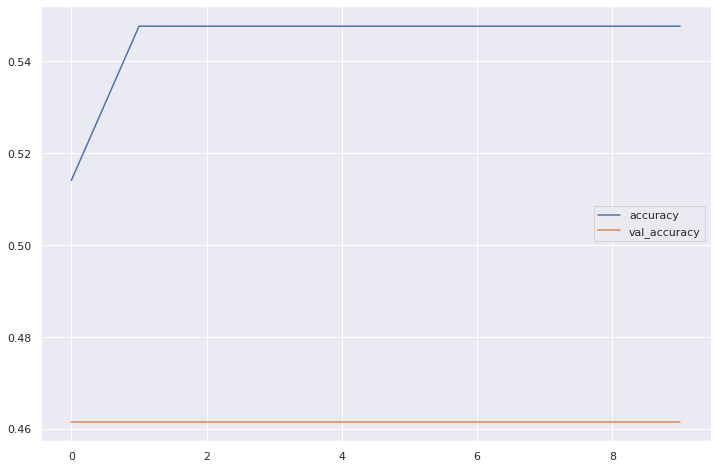

In [7]:
# 
# Model 7 - hidden state output from last timestep in GRU with much larger numer of units
#

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.GRU(512),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 35s 21ms/sample - loss: 1.6765 - accuracy: 0.5081 - val_loss: 1.4891 - val_accuracy: 0.5240
Epoch 2/10
1669/1669 [==============================] - 28s 17ms/sample - loss: 1.4489 - accuracy: 0.5368 - val_loss: 1.4679 - val_accuracy: 0.5240
Epoch 3/10
1669/1669 [==============================] - 28s 17ms/sample - loss: 1.4408 - accuracy: 0.5368 - val_loss: 1.4737 - val_accuracy: 0.5240
Epoch 4/10
1669/1669 [==============================] - 27s 16ms/sample - loss: 1.4431 - accuracy: 0.5368 - val_loss: 1.4595 - val_accuracy: 0.5240
Epoch 5/10
1669/1669 [==============================] - 27s 16ms/sample - loss: 1.4375 - accuracy: 0.5368 - val_loss: 1.4760 - val_accuracy: 0.5240
Epoch 6/10
1669/1669 [==============================] - 28s 16ms/sample - loss: 1.4457 - accuracy: 0.5368 - val_loss: 1.4754 - val_accuracy: 0.5240
Epoch 7/10
1669/1669 [===============

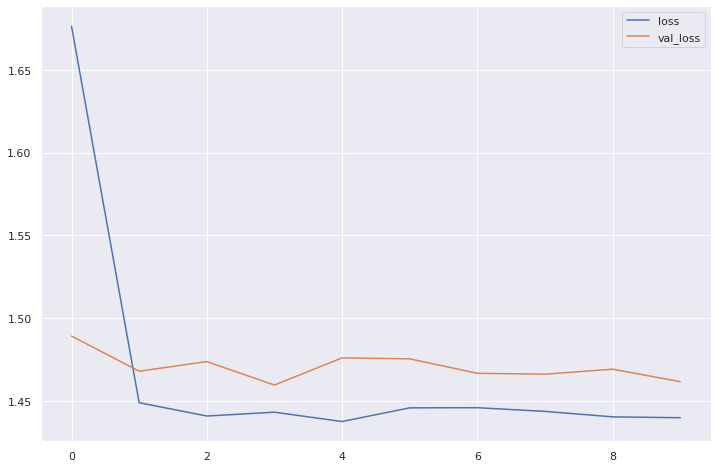

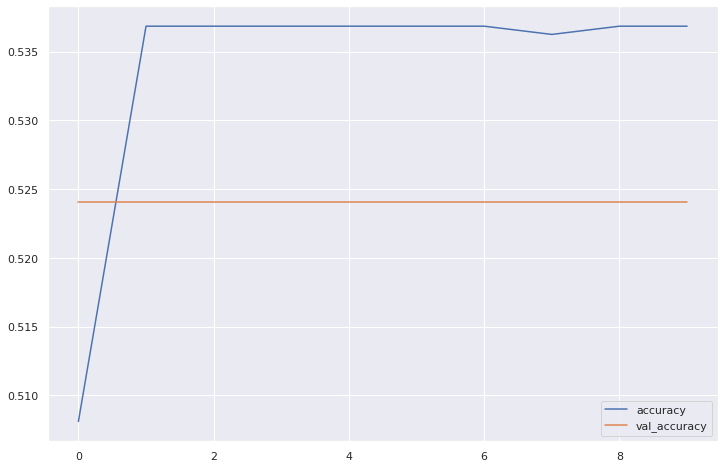

In [7]:
# 
# Model 8 - hidden state output from last timestep in LSTM with much larger numer of units
#

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.LSTM(512),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (208, 6657)
Train on 1669 samples, validate on 208 samples
Epoch 1/10
1669/1669 [==============================] - 19s 11ms/sample - loss: 1.6828 - accuracy: 0.5099 - val_loss: 1.4432 - val_accuracy: 0.5288
Epoch 2/10
1669/1669 [==============================] - 16s 10ms/sample - loss: 1.4369 - accuracy: 0.5345 - val_loss: 1.4348 - val_accuracy: 0.5288
Epoch 3/10
1669/1669 [==============================] - 17s 10ms/sample - loss: 1.4168 - accuracy: 0.5345 - val_loss: 1.4291 - val_accuracy: 0.5288
Epoch 4/10
1669/1669 [==============================] - 17s 10ms/sample - loss: 1.3605 - accuracy: 0.5345 - val_loss: 1.4097 - val_accuracy: 0.5288
Epoch 5/10
1669/1669 [==============================] - 17s 10ms/sample - loss: 1.1544 - accuracy: 0.5686 - val_loss: 1.4675 - val_accuracy: 0.4567
Epoch 6/10
1669/1669 [==============================] - 17s 10ms/sample - loss: 0.9918 - accuracy: 0.6543 - val_loss: 1.5164 - val_accuracy: 0.3702
Epoch 7/10
1669/1669 [===============

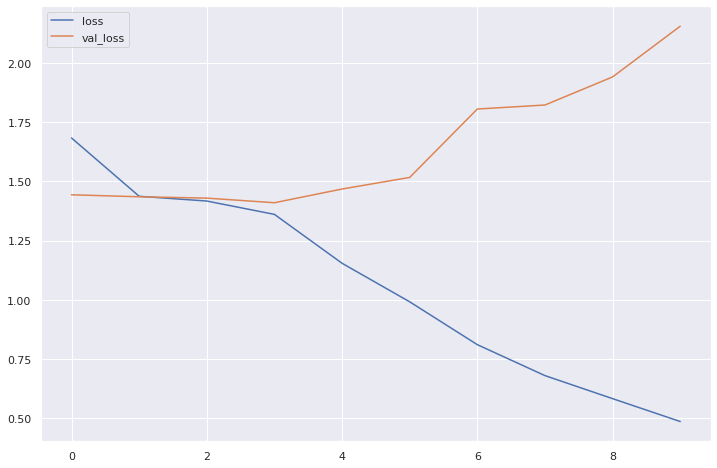

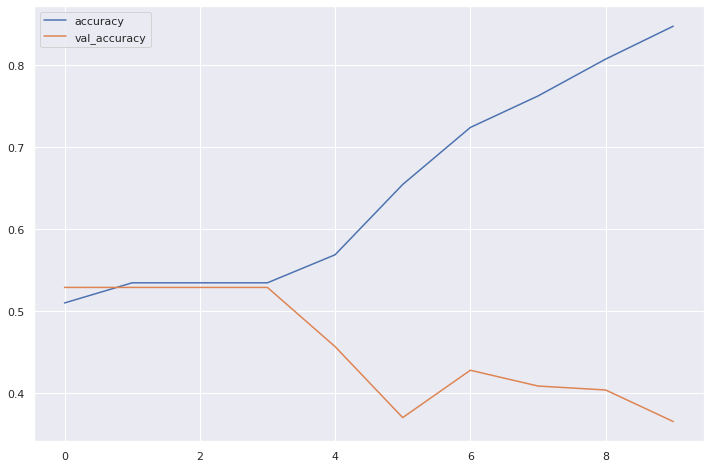

In [10]:
#
# Model 9 - concatinated hidden states from final timestep in Birirectional LSTM
#

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.SpatialDropout1D(0.1),
        layers.Bidirectional(layers.LSTM(128), merge_mode="concat"),
        layers.Dense(8, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=["accuracy"])

In [ ]:
# 
# encode dataset for batched truncated BPTT
#

In [7]:
BATCH_SIZE = 100
TRUNCATE_LENGTH = 200


def batch_pad_truncate_dataset_with_label(encoded_dataset, batch_size, truncate_length):
    longest_clip = max([len(clip) for (clip, _) in encoded_dataset])
    # we want a +1*truncate_length padding even for longest clip
    num_truncate = (longest_clip // truncate_length) + 1
    # match it to integer times truncate length
    full_length = num_truncate * truncate_length
    no_truncate_batch_num = len(encoded_dataset) // batch_size

    padded_dataset = [
        (np.append(clip, np.zeros(full_length - len(clip), dtype=int)), label)
        for (clip, label) in encoded_dataset
    ]

    output = [
        (clip[m * truncate_length : (m + 1) * truncate_length], label)
        for n in tqdm(range(no_truncate_batch_num))
        for m in range(num_truncate)
        for (clip, label) in padded_dataset[n * batch_size : (n + 1) * batch_size]
    ]

    return output

encoded_dataset = encode_dataset(dataset, encoder, label_encoder)
batch_truncated_encoded_dataset = batch_pad_truncate_dataset_with_label(encoded_dataset, BATCH_SIZE, TRUNCATE_LENGTH)
print(batch_truncated_encoded_dataset[0][0].shape)

100%|██████████| 20/20 [00:00<00:00, 388.16it/s]

(200,)


In [8]:
# 
# Model 9 - hidden state output from final timestep by stateful GRU learnt using truncated BPTT
#


test set shape: (7400, 200)
Train on 59200 samples, validate on 7400 samples
Epoch 1/10
59200/59200 [==============================] - 57s 955us/sample - loss: 1.5094 - accuracy: 0.5055 - val_loss: 1.0444 - val_accuracy: 0.7400
Epoch 2/10
59200/59200 [==============================] - 41s 692us/sample - loss: 1.4593 - accuracy: 0.5128 - val_loss: 1.0592 - val_accuracy: 0.7215
Epoch 3/10
59200/59200 [==============================] - 40s 680us/sample - loss: 1.3657 - accuracy: 0.5453 - val_loss: 1.0145 - val_accuracy: 0.7243
Epoch 4/10
59200/59200 [==============================] - 42s 704us/sample - loss: 1.2687 - accuracy: 0.5818 - val_loss: 1.0483 - val_accuracy: 0.7099
Epoch 5/10
59200/59200 [==============================] - 41s 685us/sample - loss: 1.1975 - accuracy: 0.6069 - val_loss: 1.0832 - val_accuracy: 0.7020
Epoch 6/10
59200/59200 [==============================] - 42s 701us/sample - loss: 1.1434 - accuracy: 0.6249 - val_loss: 1.1575 - val_accuracy: 0.7003
Epoch 7/10
59200/

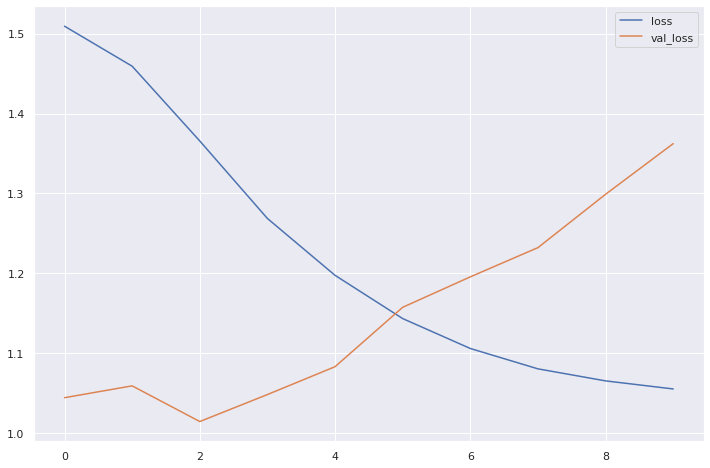

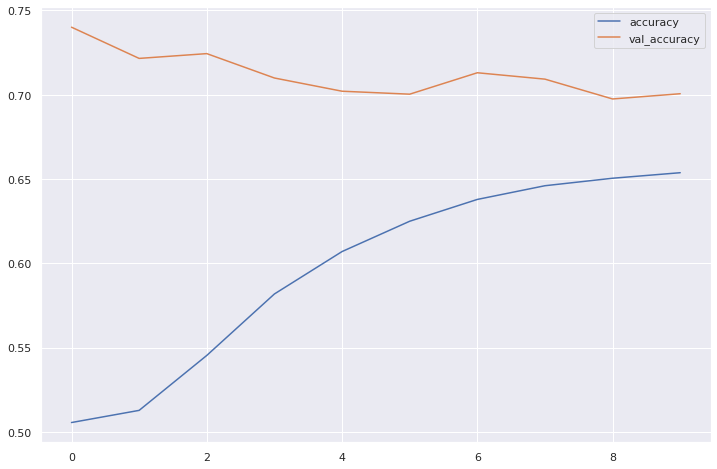

In [9]:
# stateful LSTM feeding in truncated word sequences

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(
            len(encoder),
            EMBEDDING_SIZE,
            batch_input_shape=[BATCH_SIZE, TRUNCATE_LENGTH],
        ),
        layers.LSTM(64, stateful=True,),
        layers.Dense(8, activation="softmax"),
    ]
)


model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(
    model,
    batch_truncated_encoded_dataset,
    visualise_metrics=["accuracy"],
    shuffle_dataset=False,
    batch_size=BATCH_SIZE,
)

In [19]:
#
# Q&A
#
# question 1: What are the benefits and downsides of the RNN-based representation over the bag of words representation
# used last week? How would availability of data affect your answer?
#
# RNN-based representation can retain more long distance dependencies, using the hidden layers through different timesteps
# to include historical information of each step of a sequence, while bag-of-words based approach doesn't factor in the
# sequential structure of text, rather just formulate the co-occurence probability of words within the set window.
#
# Generally speaking, RNNs are able to model more information from the input than bag-of-words based approach.
# However, when data availability is very limited, insufficiently trained RNNs may not be able to formulate the
# information correctly, therefore may result in a worse accuracy performance.


# quesiton 2: One possible architectural variant is to use only the final hidden state of the RNN as the document 
# representation (i.e., x) rather than the average of the hidden states over time. How does this work? 
# What are the potential benefits and downsides to this representation?
#
# In theory, the last hidden state include the feature activated through RNN weights from all the previous timestep inputs, 
# while input on recent timesteps can have a bigger impact to the state/output than earlier timesteps if using vanilla RNN.
# When sufficiently trained, the final hidden state of especially LSTM/GRU should include all information from previous
# timesteps, and should have no worse performance than the average of the whole sequence. 
# When sufficiently trained, LSTM should show better performance than GRU, while GRU is easier to train.
#
# The practical experiments show some interesting results here: 
# 1) when using the average of hidden states of all timesteps, held-out accuracy: RNN=0.49, LSTM=0.54, GRU=0.55,
# 2) final cell state of LSTM, held-out accuracy=0.56
# 3) final hidden state, held-out accuracy: LSTM=0.55, LSTM(large)=0.59, GRU=0.52, GRU(larger)=0.57
# 
# From the results, using the final hidden state/cell state as doc representation generally yields better performance,
# except GRU with relatively small units.
#
# On implementation on Tensorflow, it is just a difference to control whether to return_sequence or just the output.
#
# Pros: 
# 1) it is more concise computational wise for training using only the final hidden state
# 2) when sufficiently trained, it uses a better mechanism to represent historical information in the sequence than a simple average
# by which, past time steps information may have been repeated added to the result
# 
# Cons:
# 1) training model to represent long sequence can be tricky due to vanishing gradient problem
# 2) it requires good availability of data to have the model properly trained


# quesiton3: Try different RNN architectures, e.g., simple Elman RNNs or GRUs or LSTMs. Which ones work best?
#
# GRU trains slightly faster than LSTM as it has less parameters to train, while LSTM shows better performance especially
# when using the final hidden state as doc representation.


# question 4: What happens if you use a bidirectional LSTM?
#
# Bidirectional LSTM shows signs of overfitting - with the increase of the training accurarcy, the validation accurarcy
# is decreasing.

# optional: use Truncated Backpropagation Through Time (truncated BPTT)
#
# The performance is marginal better as truncated BPTT reduces the vanishing gradients problem in learning long sequences,
# and better modelled long distance dependencies here for classification.